In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw1.ipynb")

<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Homework 1: Web Scraping, Data Parsing, and EDA

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader



<hr style='height:2px'>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Exercise **responsible scraping**. Web servers can become slow or unresponsive if they receive too many requests from the same source in a short amount of time. Use a short delay between requests in your code.  
- Web scraping requests can take several minutes. This is another reason why you should not wait until the last minute to do this homework.
- Plots should be legible and interpretable without having to refer to the code that generated them.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- Enable scrolling output on cells with very long output.
- Please remove unused cells and don't include large portions of commented-out code in your submission.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (this can take a few minutes).
- All cell output should be visible and it should be clear from the cell number that everything was run in order.

In [2]:
import os
import pickle
import re
import time

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

<hr style='height:2px'>

## ⭐ Follow the stars with IMDb's list of The Top 100 Stars

### Overview
In this assignment you'll practice scraping, parsing, and analyzing HTML data pulled from web.

Specifically, you'll extract information about each person on listed on a historcal snapshot of IMDb's "starmeter", perform some EDA, ask some questions of the data, and interpret your findings.

For example, we might like to know: 
- What is the relationship between when a performer started their career and their total number of acting credits? 
- How many stars started as child actors?
- How do the distribution of ages compare across genders?
- Who is the most prolific actress or actor in the list? 

These questions and more are addressed in details below. 

## Part 1 - Scraping and Parsing

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class="exercise"><b>Q1 - Scrape Top Stars List</b></div>

First, use [The Internet Archive's Wayback Machine](https://archive.org/web/) to find the URL for the September 13th, 2023 snapshot of the [IMDB starmeter page](https://www.imdb.com/chart/starmeter/). Store the URL you find as a string called `snapshot_url`.

Next, use `requests` to scrape the snapshot URL and store the resulting `Response` object as `snapshot_response`. 

Finally, store the response's status code in `status_code`.

**Note:** Checking the status code after your requests can save you time by catching problems early. Using the [headers](https://requests.readthedocs.io/en/latest/user/quickstart/#custom-headers) dictionary defined below with your requests can help provent failures when used on some pages.
</div>

In [3]:
# In this notebook, pass this as the `headers` argument when using requests.get()
headers = {'User-Agent': 'Mozilla/5.0'}

In [4]:
snapshot_url = "https://web.archive.org/web/20230913220443/https://www.imdb.com/chart/starmeter/"
snapshot_response = requests.get(snapshot_url, headers=headers)
status_code = snapshot_response.status_code

In [5]:
# It's always a good idea to check your status code!
print(f"Response statuse code: {status_code}")

Response statuse code: 200


In [6]:
grader.check("q1")

q1 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q2 - Making BeautifulSoup</b></div>

Create a Beautiful Soup object named `star_soup` from the HTML content in `snapshot_response`.


In [7]:
star_soup = BeautifulSoup(snapshot_response.text, 'html.parser')

In [8]:
# Taste the soup! You should see HTML code here
print(star_soup.prettify()[:1000])

<!DOCTYPE html>
<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
 <head>
  <script charset="utf-8" src="/_static/js/bundle-playback.js?v=1WaXNDFE" type="text/javascript">
  </script>
  <script charset="utf-8" src="/_static/js/wombat.js?v=txqj7nKC" type="text/javascript">
  </script>
  <script>
   window.RufflePlayer=window.RufflePlayer||{};window.RufflePlayer.config={"autoplay":"on","unmuteOverlay":"hidden"};
  </script>
  <script src="/_static/js/ruffle.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   __wm.init("https://web.archive.org/web");
  __wm.wombat("https://www.imdb.com/chart/starmeter/","20230913220443","https://web.archive.org/","web","/_static/",
	      "1694642683");
  </script>
  <link href="/_static/css/banner-styles.css?v=S1zqJCYt" rel="stylesheet" type="text/css"/>
  <link href="/_static/css/iconochive.css?v=qtvMKcIJ" rel="stylesheet" type="text/css"/>
  <!-- End Wayback Rewrite

In [9]:
grader.check("q2")

q2 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q3 - Parse Stars</b></div>

Implement the `parse_stars` function described below, pass it your `star_soup`, and save the result in a variable called `star_list`. 

>**Note:** We use the 'fullcredits' URL for credits rather than the main star page which would require browser automation to extract all credits.
>
>**Hint:** Throughout this assignment you'll likely find it useful to create small 'helper' functions which are then used by your larger functions like `parse_stars`

```
Function
--------
parse_stars

Input
------
star_soup: BeautifulSoup object created from starmeter page
   
Returns
-------
a list of dictionaries; each dictionary corresponds to a listed star with the following data:

    name: (str) the name of the star
    roles: (list) star's roles (lowercase) in the order they appear on starmeter
    star_url: (str) current URL (non-snapshot) linked by star's name (exclude '/?' query)
    credits_url: (str) current URL of star's simplified credits page

Example Output:
--------

[
...
{'name': 'Diana Lee Inosanto',
 'roles': ['actress', 'director', 'producer'],
 'star_url': 'https://www.imdb.com/name/nm0409262',
 'credits_url': 'https://www.imdb.com/name/nm0409262/fullcredits'},
...
]

```
</div>

In [10]:
# Implement parse_stars
def parse_stars(star_soup):
    star_section = star_soup.find_all('a', class_='ipc-title-link-wrapper')
    star_list = []
    for star_link_element in star_section:
        star_info = {}

        star_info['name'] = star_link_element.find('h3', class_='ipc-title__text').text.strip()
        
        star_info['roles'] = []

        roles_section = star_link_element.find_next('ul', class_='ipc-inline-list')
        if roles_section:
            roles = roles_section.find_all('li', class_='ipc-inline-list__item')
            star_info['roles'] = [role.text.strip().lower() for role in roles]

        star_url = star_link_element['href']
        star_url_parts = star_url.split("?")[0].split("https:")
        star_info['star_url'] = f'https:{star_url_parts[-1]}'
        star_info['credits_url'] = f'https:{star_url_parts[-1]}''fullcredits'

        star_list.append(star_info)
        if len(star_list)==100:
            return star_list

    return star_list

In [11]:
star_list = parse_stars(star_soup)

In [12]:
# Inspect one list entry
star_list[42]

{'name': 'Diana Lee Inosanto',
 'roles': ['actress', 'director', 'producer'],
 'star_url': 'https://www.imdb.com/name/nm0409262/',
 'credits_url': 'https://www.imdb.com/name/nm0409262/fullcredits'}

In [13]:
grader.check("q3")

q3 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q4 - Add BeautifulSoup Pages</b></div>

Now, we'd like to update each dictionary in `star_list` to include a BeautifulSoup object corresponding to that star's `star_url` and `credits_url`. We'll use the keys `star_page` and `credits_page` for these new entries in the dictionaries.

To accomplish this, implement the `add_pages` function below which takes the current `star_list` and returns a new list with the updated dictionaries.

Code we've provided will then use your `add_pages` implementation to create `star_pages`, which is what we'll call the list with the updated dictionaries.
</div>

In [14]:
def add_pages(star_list):
    updated_star_list = []
    
    for star_info in star_list:
        star_url = star_info['star_url']
        credits_url = star_info['credits_url']
        
        star_response = requests.get(star_url,headers = headers)
        credits_response = requests.get(credits_url,headers = headers)
        
        if star_response.status_code == 200 and credits_response.status_code == 200:
            star_soup = BeautifulSoup(star_response.text, 'html.parser')
            credits_soup = BeautifulSoup(credits_response.text, 'html.parser')
            
            star_info['star_page'] = star_soup
            star_info['credits_page'] = credits_soup
            
        updated_star_list.append(star_info)
        time.sleep(1)
    return updated_star_list

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
Scraping all these pages can take 5-10 minutes if you're using a small delay between requests with `time.sleep`(as you should!).

To prevent you from having to re-scrape this data everytime you run your notebook we've provided some code below.

The code first checks if a [pickle file](https://docs.python.org/3/library/pickle.html), `star_pages.pkl`, exists from a previous scraping. If it does, it'll try to load from it. If the file doesn't exist, if there's any error during loading, or if the loaded `star_pages` doesn't have 100 entries, it'll run your `add_pages` scraping function and save the results to the pickle file.

**Note:** The code will load your pickle file and assume everything is fine as long as it contains 100 entries, but it does not check the entries themselves. If there are issues with the entries themselves, you'll need to delete your current pickle file so that you can re-scrape.
</div>

In [15]:
# Provided code
def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Check if pickle file exists
pickle_filename = "star_pages.pkl"
SCRAPE = True # assume we're scraping

#unless we have a good pkl file
if os.path.exists(pickle_filename):
    try:
        star_pages = load_from_pickle(pickle_filename)
        assert len(star_pages) == 100, "star_pages should have 100 entries!"
        print("Pickle file of previous scraping loaded!")
        SCRAPE = False
    except Exception as e:
        print(f"Error loading from pickle: {e}. Will re-scrape data.")

if SCRAPE:
    start_time = time.time()
    # Here is where your scraping function is run
    star_pages = add_pages(star_list)
    end_time = time.time()
    scraping_time = round((end_time-start_time)/60, 2)
    print(f"Scraping took {scraping_time} minutes!")
    save_to_pickle(star_pages, pickle_filename)

Pickle file of previous scraping loaded!


In [16]:
grader.check("q4")

q4 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q5 - Parse Star Pages</b></div>

Implement the function `parse_star_pages` described below, which takes `star_pages` as an input and returns a *new* list of dictionaries, `star_data`, which includes more extensive information about each star extracted from their `star_page` and `credits_page`. 

```
Function
--------
create_star_data

Input
------
star_pages (list of dictionaries)
   
Returns
-------

a list of dictionaries; each dictionary corresponds to a star profile and has the following data:

    name: (str) the name of the star
    primary_role: (str) type of role this star is most known for (see note about heuristic below)
    roles: (str) all role types for this star listed on starmeter page
    gender: (str) 'woman', 'man', 'non-binary', or 'unknown' (we provide a helper function)  
    year_born : (int/str) year star was born or 'unknown' if not included on star_page
    first_credit: (str) title of their first credit in their capacity designated by 'primary_role'
    year_first_credit: (int) year of their first credit in their capacity designated by 'primary_role'
    num_credits: (int) number of movie or TV show recieved in their capacity designated by 'primary_role'
    
--------
Example:
[
...
{'name': 'Brad Pitt',
 'primary_role': 'actor',
 'roles': ['producer', 'actor', 'executive'],
 'gender': 'male',
 'year_born': 1963,
 'first_credit': 'Hunk',
 'year_first_credit': 1987,
 'num_credits': 87}
]
```
</div>

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
>**Additional Implementation Notes:** 
>
>**Gender**
>- We have provided a helper function, `get_gender()`, for trying to infer gender from a given `star_page`. You may find it useful to create additional helper functions for `parse_stars` to populate the other values. You'll find that any additional helper functions you need to write will not need to be as complex as `get_gender()`.
>
>**Primary Role**
>- IMDb is primarily concerned with TV and film roles, and really, no one is a star *because* they are a producer. Use the following heuristic for determining a star's primary role: select the first role type listed on the starmeter page excluding 'music artist' and 'producer'. This will produce at least one questionable result, but that is fine.
>
>**Credits**
>- For TV credits, you don't need to consider individual episodes. You can treat the TV show as a whole as a single credit.
>- The years of some credits are ranges (e.g., 2001-2002). You should use only the starting year.

>**Hint:** Carefuly note the ordering, case, and data type of the values in each dictionary.
</div>

In [17]:
# Helper functions
def get_gender(star_page, page=None):
    # some pages have a gender identity field
    # this actually saves us in some cases where counting pronouns fails
    # due to limited bio
    gi_span = star_page.find('span', string='Gender / Gender identity')
    if gi_span is not None:
        return gi_span.next_sibling()[-1].text.lower()

    # otherwise we count pronouns
    PRONOUNS = {'female': ['she', 'her', 'hers'],
                'male': ['he', 'him', 'his'],
                'non-binary': ['they', 'them', 'their']}
    
    def count_pronouns(bio):
        pronoun_counts = [len(re.findall(rf"\W({'|'.join(pns)})\W", bio)) for pns in PRONOUNS.values()]
        return pronoun_counts

    bio = star_page.select_one('.ipc-html-content-inner-div').text.lower()
    pronoun_counts = count_pronouns(bio)
    # if no pronoun counts in bio
    if sum(pronoun_counts) == 0:
        # IMDB seems to treat 'Actor' as gender neutral, but not 'Actress'
        # Usinger 'Actor' to infer gender will get you the wrong results
        # (see Sept 4th starmeter snapshot for example)
        if star_page.find('h3', string='Actress') is not None:
            return 'female' 
        else:
            return 'unknown'
    return list(PRONOUNS.keys())[np.argmax(pronoun_counts)]

In [18]:
def create_star_data(star_pages):
    star_data = []

    for star_info in star_pages:
        star_dict = {}
        
        # Extract basic information
        star_dict['name'] = star_info['name']
        star_dict['roles'] = star_info['roles']

        # Determine gender using the provided get_gender function
        star_page = star_info['star_page']
        star_dict['gender'] = get_gender(star_page)
        
        # Extract year born
        birth_year_element = star_page.find('span', string='Born')
        if birth_year_element:
            birth_year_text = birth_year_element.find_next('span')
            if birth_year_text:
                star_dict['year_born'] = int(birth_year_text.text)
            else:
                star_dict['year_born'] = 'unknown'
        else:
            star_dict['year_born'] = 'unknown'

        # Extract primary role (heuristic: first non-prod/non-music-artist role)
        roles = star_info['roles']
        primary_role = 'unknown'
        for role in roles:
            if role.lower() not in ['music artist', 'producer']:
                primary_role = role
                break
        star_dict['primary_role'] = primary_role

        # Extract first credit and year of first credit
        credits_page = star_info['credits_page']
        first_credit_element = credits_page.find('div', class_='filmo-row').find_next('a', href=True)
        if first_credit_element:
            star_dict['first_credit'] = first_credit_element.text.strip()
            year_match = re.search(r'\d{4}', first_credit_element.text)
            if year_match:
                star_dict['year_first_credit'] = int(year_match.group())
            else:
                star_dict['year_first_credit'] = 'unknown'
        else:
            star_dict['first_credit'] = 'unknown'
            star_dict['year_first_credit'] = 'unknown'

        # Extract number of credits
        num_credits_element = credits_page.find('span', class_='filmo-category-section')
        if num_credits_element:
            num_credits_element = num_credits_element.find_next('b')
            if num_credits_element:
                num_credits_text = num_credits_element.text.strip()
                num_credits_match = re.search(r'\d+', num_credits_text)
                if num_credits_match:
                    star_dict['num_credits'] = int(num_credits_match.group())
                else:
                    star_dict['num_credits'] = 'unknown'
            else:
                star_dict['num_credits'] = 'unknown'
        else:
            star_dict['num_credits'] = 'unknown'

        star_data.append(star_dict)

    return star_data

In [42]:
star_data = create_star_data(star_pages)
star_data

[{'name': 'Emily Rudd',
  'roles': ['actress'],
  'gender': 'female',
  'year_born': 'unknown',
  'primary_role': 'actress',
  'first_credit': 'One Piece',
  'year_first_credit': 'unknown',
  'num_credits': 'unknown'},
 {'name': 'Mary Elizabeth Winstead',
  'roles': ['actress', 'producer', 'soundtrack'],
  'gender': 'female',
  'year_born': 'unknown',
  'primary_role': 'actress',
  'first_credit': 'A Gentleman in Moscow',
  'year_first_credit': 'unknown',
  'num_credits': 'unknown'},
 {'name': 'Morgan Davies',
  'roles': ['actor', 'second unit director or assistant director'],
  'gender': 'male',
  'year_born': 'unknown',
  'primary_role': 'actor',
  'first_credit': 'One Piece',
  'year_first_credit': 'unknown',
  'num_credits': 'unknown'},
 {'name': 'Mackenyu',
  'roles': ['actor', 'soundtrack'],
  'gender': 'male',
  'year_born': 'unknown',
  'primary_role': 'actor',
  'first_credit': 'Dragons of Wonderhatch',
  'year_first_credit': 'unknown',
  'num_credits': 'unknown'},
 {'name': '

In [20]:
# Inspect an element from star_data
star_data[-1]

{'name': 'Brad Pitt',
 'roles': ['producer', 'actor', 'executive'],
 'gender': 'male',
 'year_born': 'unknown',
 'primary_role': 'actor',
 'first_credit': 'Untitled Chris Cornell Documentary',
 'year_first_credit': 'unknown',
 'num_credits': 'unknown'}

In [21]:
grader.check("q5")

q5 results:
    q5 - 1 result:
        ✅ Test case passed

    q5 - 2 result:
        ✅ Test case passed

    q5 - 3 result:
        ✅ Test case passed

    q5 - 4 result:
        ✅ Test case passed

    q5 - 5 result:
        ✅ Test case passed

    q5 - 6 result:
        ❌ Test case failed
        Trying:
            def test_year_born2(star_data):
                df = pd.DataFrame(star_data)
                assert np.isclose(df.loc[df['year_born'].str.lower() != 'unknown', 'year_born'].astype(int).mean(), 1981.3, atol=2),  "Your values for 'year_born' are incorrect"
        Expecting nothing
        ok
        Trying:
            test_year_born2(star_data)
        Expecting nothing
        **********************************************************************
        Line 5, in q5 5
        Failed example:
            test_year_born2(star_data)
        Exception raised:
            Traceback (most recent call last):
              File "/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q5 5[1]>", line 1, in <module>
                test_year_born2(star_data)
              File "<doctest q5 5[0]>", line 3, in test_year_born2
                assert np.isclose(df.loc[df['year_born'].str.lower() != 'unknown', 'year_born'].astype(int).mean(), 1981.3, atol=2),  "Your values for 'year_born' are incorrect"
            AssertionError: Your values for 'year_born' are incorrect

    q5 - 7 result:
        ✅ Test case passed

    q5 - 8 result:
        ✅ Test case passed

    q5 - 9 result:
        ❌ Test case failed
        Trying:
            def test_year_first_credit1(star_data):
                assert {type(s['year_first_credit']) for s in star_data} == {int}, "All 'year_first_credit' values should be of type int"
        Expecting nothing
        ok
        Trying:
            test_year_first_credit1(star_data) 
        Expecting nothing
        **********************************************************************
        Line 4, in q5 8
        Failed example:
            test_year_first_credit1(star_data) 
        Exception raised:
            Traceback (most recent call last):
              File "/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q5 8[1]>", line 1, in <module>
                test_year_first_credit1(star_data)
              File "<doctest q5 8[0]>", line 2, in test_year_first_credit1
                assert {type(s['year_first_credit']) for s in star_data} == {int}, "All 'year_first_credit' values should be of type int"
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: All 'year_first_credit' values should be of type int

    q5 - 10 result:
        ❌ Test case failed
        Trying:
            def test_year_first_credit2(star_data):
                assert np.isclose(pd.DataFrame(star_data)['year_first_credit'].astype(int).mean(), 1999.88, atol=5),  "Some values for 'year_first_credit' are incorrect"
        Expecting nothing
        ok
        Trying:
            test_year_first_credit2(star_data) 
        Expecting nothing
        **********************************************************************
        Line 4, in q5 9
        Failed example:
            test_year_first_credit2(star_data) 
        Exception raised:
            Traceback (most recent call last):
              File "/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q5 9[1]>", line 1, in <module>
                test_year_first_credit2(star_data)
              File "<doctest q5 9[0]>", line 2, in test_year_first_credit2
                assert np.isclose(pd.DataFrame(star_d

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q6 - Creating a DataFrame and Saving a CSV</b></div>

Use `star_data` to create a Pandas DataFrame called `star_df` and save it to disk as `data/star_data.csv`.

In [22]:
star_df = pd.DataFrame(star_data)
csv_file_path = 'data/star_data.csv'
star_df.to_csv(csv_file_path, index=False)
print(star_df.head())

                      name                                              roles  \
0               Emily Rudd                                          [actress]   
1  Mary Elizabeth Winstead                    [actress, producer, soundtrack]   
2            Morgan Davies  [actor, second unit director or assistant dire...   
3                 Mackenyu                                [actor, soundtrack]   
4              Iñaki Godoy                                            [actor]   

   gender year_born primary_role            first_credit year_first_credit  \
0  female   unknown      actress               One Piece           unknown   
1  female   unknown      actress   A Gentleman in Moscow           unknown   
2    male   unknown        actor               One Piece           unknown   
3    male   unknown        actor  Dragons of Wonderhatch           unknown   
4    male   unknown        actor               One Piece           unknown   

  num_credits  
0     unknown  
1     unknow

In [23]:
grader.check("q6")

q6 results: All test cases passed!

## Part 2 - Pandas & EDA

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q7 - Load CSV</b></div>

For the sake of consistency, we've provide our own CSV file, `data/star_data_2023_staff.csv`, which you should use for the rest of the notebook. Use this CSV to create a Pandas DataFrame called `df`. 
</div>

In [24]:
df = pd.read_csv('data/star_data_2023_staff.csv')

In [25]:
# Take a peek
df.head(20)

,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits
0,Emily Rudd,actress,['actress'],female,1993,Boy & Bear: Three Headed Woman,2013,26
1,Mary Elizabeth Winstead,actress,"['actress', 'producer', 'soundtrack']",female,1984,Touched by an Angel,1997,59
2,Morgan Davies,actor,"['actor', 'second unit director or assistant d...",male,2001,Green Fire Envy,2008,19
3,Mackenyu,actor,"['actor', 'soundtrack']",male,1996,Astro kyûdan,2005,46
4,Iñaki Godoy,actor,['actor'],male,2003,Blue Demon,2016,11
5,Danny Masterson,actor,"['actor', 'producer', 'soundtrack']",male,1976,Jake and the Fatman,1988,68
6,Bijou Phillips,actress,"['actress', 'costume and wardrobe department',...",female,1980,Sublime: Wrong Way,1997,38
7,Stephanie Nur,actress,['actress'],female,1988,Tanzcafe Jenseits,2009,13
8,Jeff Ward,actor,"['actor', 'writer', 'producer']",male,1986,Law & Order: Criminal Intent,2005,31
9,Natasha Liu Bordizzo,actress,['actress'],female,1994,"Crouching Tiger, Hidden Dragon: Sword of Destiny",2016,16


In [26]:
grader.check("q7")

q7 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q8 - Age at First Credit</b></div>

Add a new column to your dataframe with the *approximate* age of each star at the time of their first credit. Name this new column `age_at_first_credit`.

Next, creat a visualization which compares each `age_at_first_credit` across the 100 stars. You'll need to make some choices as to what makes a useful and legible plot.

>**NOTE:** We say *approximate* age because we've only collected the year of birth as several star pages do not include a full birth date. **The approximate age of a star in a given year should be the difference between that year and the star's birth year.**
</div>

In [27]:
# add age_at_first_credit column
df['age_at_first_credit'] = df['year_first_credit'] - df['year_born']
df.tail(10)

,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
90,Nicolas Cage,actor,"['actor', 'producer', 'director']",male,1964,The Best of Times,1981,116,17
91,Ana de Armas,actress,"['actress', 'producer']",female,1988,Una rosa de Francia,2006,34,18
92,Pom Klementieff,actress,"['actress', 'writer']",female,1986,Des mots,2006,46,20
93,Teresa Palmer,actress,"['actress', 'producer', 'writer']",female,1986,Orientation,2004,38,18
94,Tom Hanks,actor,"['producer', 'actor', 'writer']",male,1956,He Knows You're Alone,1980,96,24
95,Whitney Cummings,writer,"['writer', 'actress', 'producer']",female,1982,Last Call with Carson Daly,2007,19,25
96,Michael Keaton,actor,"['actor', 'additional crew', 'producer']",male,1951,Mister Rogers' Neighborhood,1974,94,23
97,Gal Gadot,actress,"['actress', 'producer', 'soundtrack']",female,1985,Shemesh,1999,38,14
98,Harrison Ford,actor,"['actor', 'writer', 'producer']",male,1942,Dead Heat on a Merry-Go-Round,1966,87,24
99,Brad Pitt,actor,"['producer', 'actor', 'executive']",male,1963,Hunk,1987,87,24


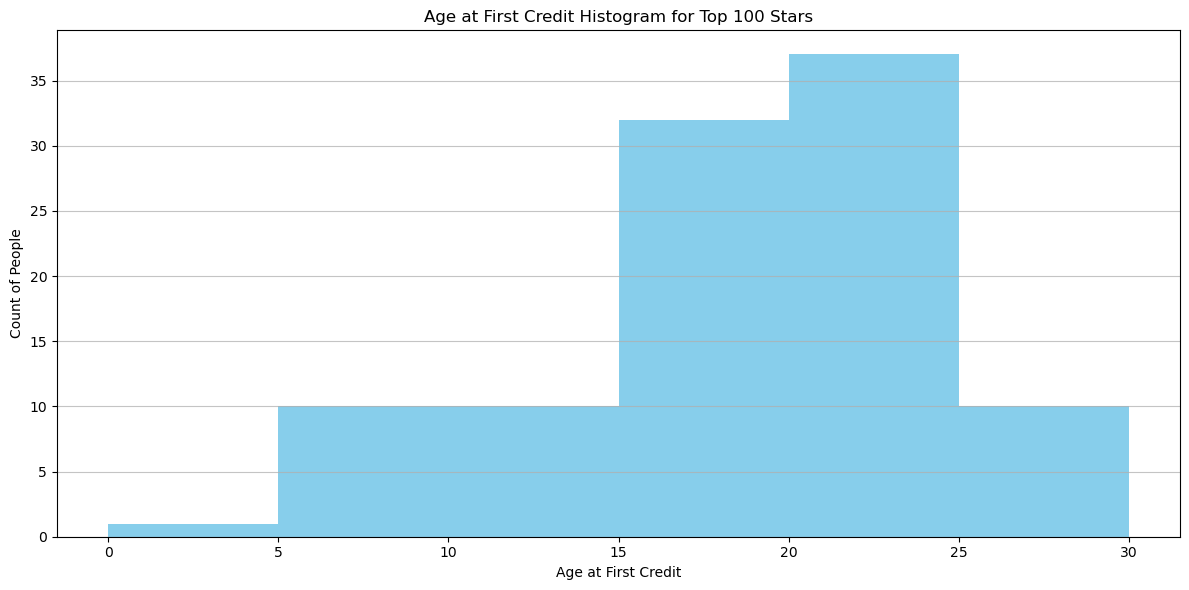

In [28]:
# Visualize the new column values
plt.figure(figsize=(12, 6))
plt.hist(df['age_at_first_credit'], bins=range(0, max(df['age_at_first_credit']) + 6, 5), color='skyblue')
plt.xlabel('Age at First Credit')
plt.ylabel('Count of People')
plt.title('Age at First Credit Histogram for Top 100 Stars')
plt.xticks(range(0, max(df['age_at_first_credit']) + 6, 5))  # Set x-axis ticks at intervals of 5
plt.grid(axis='y', alpha=0.75)  # Add grid lines on the y-axis
plt.tight_layout()

# Show the histogram
plt.show()

In [29]:
# You should visually inspect the values too
df.head()

,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
0,Emily Rudd,actress,['actress'],female,1993,Boy & Bear: Three Headed Woman,2013,26,20
1,Mary Elizabeth Winstead,actress,"['actress', 'producer', 'soundtrack']",female,1984,Touched by an Angel,1997,59,13
2,Morgan Davies,actor,"['actor', 'second unit director or assistant d...",male,2001,Green Fire Envy,2008,19,7
3,Mackenyu,actor,"['actor', 'soundtrack']",male,1996,Astro kyûdan,2005,46,9
4,Iñaki Godoy,actor,['actor'],male,2003,Blue Demon,2016,11,13


In [30]:
grader.check("q8")

q8 results: All test cases passed!

<!-- END QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q9 - Subsetting and Sorting</b></div>

In this section you'll subset and sort the DataFrame to answer a pair of questions:
</div>

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q9.1 - Child Stars</b></div>

Which stars received their first credit **before the age of 11?**

Store the resulting dataframe as `child_stars`sorted by `age_at_first_credit` in **ascending** order.\
Store the number of such "child stars" in `num_child_stars`.
</div>

In [31]:
child_stars = df[df['age_at_first_credit'] < 11]
child_stars = child_stars.sort_values(by='age_at_first_credit', ascending=True)
num_child_stars = len(child_stars)

print ("{} stars received their first credit before the age of 11.".format(num_child_stars))
display(child_stars)

12 stars received their first credit before the age of 11.


,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
89,Sunny Sandler,actress,['actress'],female,2008,Grown Ups,2010,22,2
44,Javier Bardem,actor,"['actor', 'producer', 'music department']",male,1969,El pícaro,1974,74,5
86,Leonardo DiCaprio,actor,"['producer', 'actor', 'writer']",male,1974,Romper Room,1979,47,5
32,Halle Bailey,actress,"['actress', 'composer', 'music department']",female,2000,Last Holiday,2006,18,6
39,Dakota Fanning,actress,"['actress', 'producer', 'director']",female,1994,My Neighbor Totoro,2000,72,6
2,Morgan Davies,actor,"['actor', 'second unit director or assistant d...",male,2001,Green Fire Envy,2008,19,7
82,Molly Gordon,actress,"['actress', 'writer', 'director']",female,1994,I Am Sam,2001,23,7
84,Evan Rachel Wood,actress,"['actress', 'director', 'writer']",female,1987,"In the Best of Families: Marriage, Pride & Mad...",1994,66,7
10,Ivanna Sakhno,actress,"['actress', 'producer']",female,1997,Lesya plyus Roma,2005,21,8
31,Gabriel Macht,actor,"['actor', 'producer', 'director']",male,1972,Why Would I Lie?,1980,35,8


In [32]:
grader.check("q9.1")

q9.1 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q9.2 - Late Bloomers</b></div>

Which stars received their first credit at **26-years-old or older?**

Store the resulting dataframe as `late_bloomers` sorted by `age_at_first_credit` in **descending** order.\
Store the number of such "late bloomers" in `num_late_bloomers`.
</div>

In [33]:
late_bloomers = df[df['age_at_first_credit'] >= 26]
late_bloomers = late_bloomers.sort_values(by='age_at_first_credit', ascending=False)
num_late_bloomers = len(late_bloomers)

print ("{} stars received their first credit at 26 or older.".format(num_late_bloomers))
display(late_bloomers)

7 stars received their first credit at 26 or older.


,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
11,Ray Stevenson,actor,"['actor', 'soundtrack']",male,1964,A Woman's Guide to Adultery,1993,64,29
54,Natasia Demetriou,actress,"['actress', 'writer', 'director']",female,1984,Jamie Demetriou: Channel 4 Comedy Blaps,2013,35,29
71,Jimmy Buffett,actor,"['music artist', 'actor', 'producer']",male,1946,Rancho Deluxe,1975,18,29
15,Vincent Regan,actor,"['actor', 'director', 'writer']",male,1965,Between the Lines,1992,116,27
83,Timothy Olyphant,actor,"['actor', 'producer', 'soundtrack']",male,1968,77 Sunset Strip,1995,76,27
67,Sarah Rafferty,actress,"['actress', 'producer', 'soundtrack']",female,1972,Trinity,1998,37,26
70,Kate Fleetwood,actress,"['actress', 'soundtrack']",female,1972,Getting Hurt,1998,55,26


In [34]:
grader.check("q9.2")

q9.2 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q10 - Visualization  </b></div>

In this section you'll use your Python visualization skills to further explore the data:
</div>

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q10.1  - Exploring Trends</b></div>

Create 2 [scatter plots](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html?highlight=scatter#matplotlib.axes.Axes.scatter): one showing the relationship between **age at first movie** and number of credits, the other between **year born** and number of credits.

What can you say about these relationships? Are there any apparent outliers? Please limit your written responses to 4 sentences or fewer.
</div>

##TBD

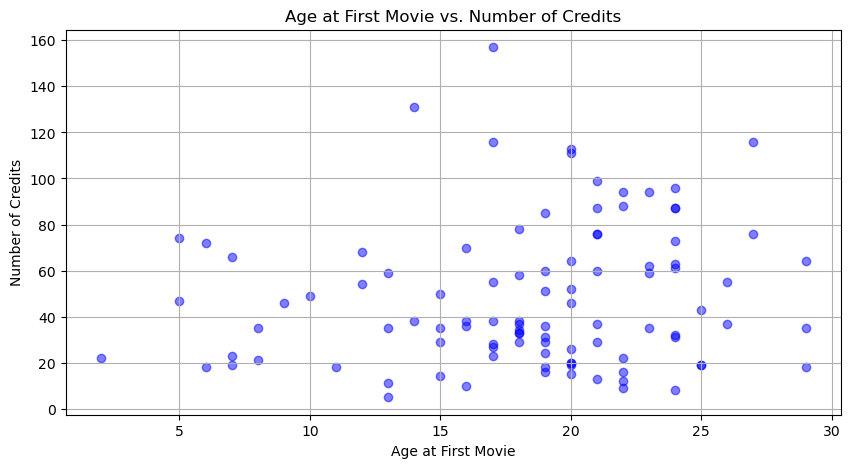

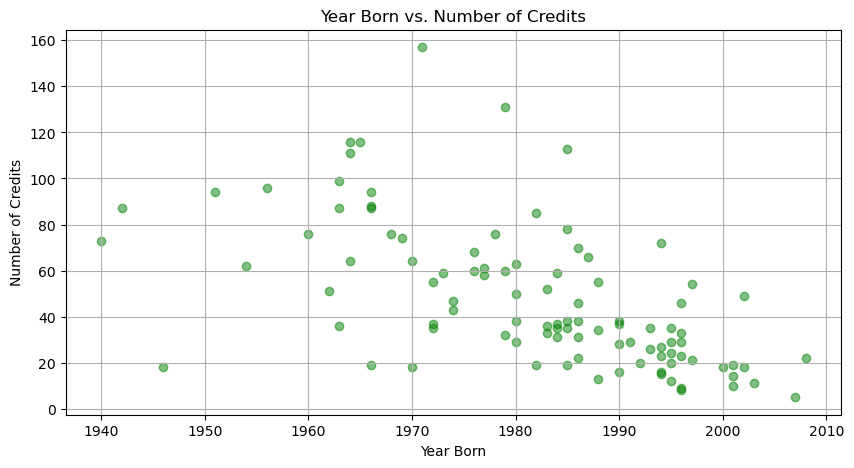

In [35]:
# your code here
# Scatter plot: Age at First Movie vs. Number of Credits
plt.figure(figsize=(10, 5))
plt.scatter(df['age_at_first_credit'], df['num_credits'], alpha=0.5, color='blue')
plt.title('Age at First Movie vs. Number of Credits')
plt.xlabel('Age at First Movie')
plt.ylabel('Number of Credits')
plt.grid(True)
plt.show()

# Scatter plot: Year Born vs. Number of Credits
plt.figure(figsize=(10, 5))
plt.scatter(df['year_born'], df['num_credits'], alpha=0.5, color='green')
plt.title('Year Born vs. Number of Credits')
plt.xlabel('Year Born')
plt.ylabel('Number of Credits')
plt.grid(True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q10.2 - Age Distributions</b></div>

Let's look at the distribution of movie and TV performers' ages by gender.

Create two plots, each plot consisting of **two overlayed [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html?highlight=hist#matplotlib.pyplot.hist)** comparing the distribution of men's current ages to women's current ages.

In the first plot, the distributions should be normalized to show the *proportion* of each gender at each age.

The second plot should show the *counts* of each gender at each age. 

Finallu, interpret the resulting plots. (4 sentences or fewer)

>**NOTE 1:** Again, we are dealing with *approximate* ages as defined above.
>
>**NOTE 2:** You should exclude those whose `primary_role` is not 'actor' or 'actress' from your analysis
</div>

##TBD

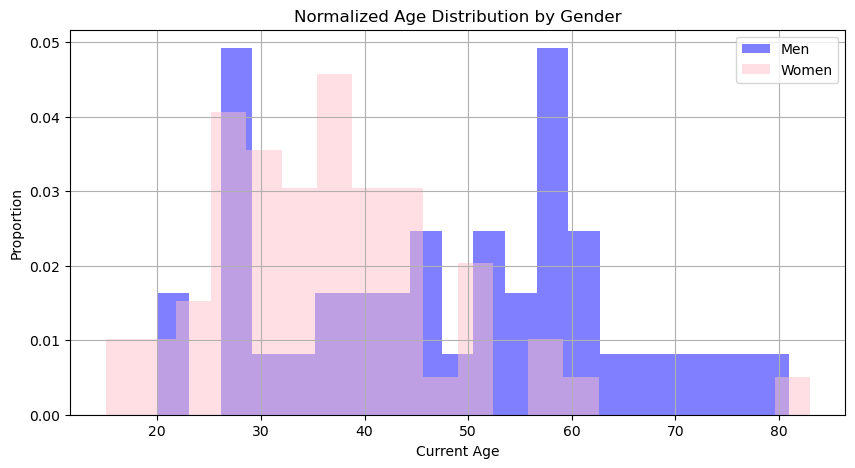

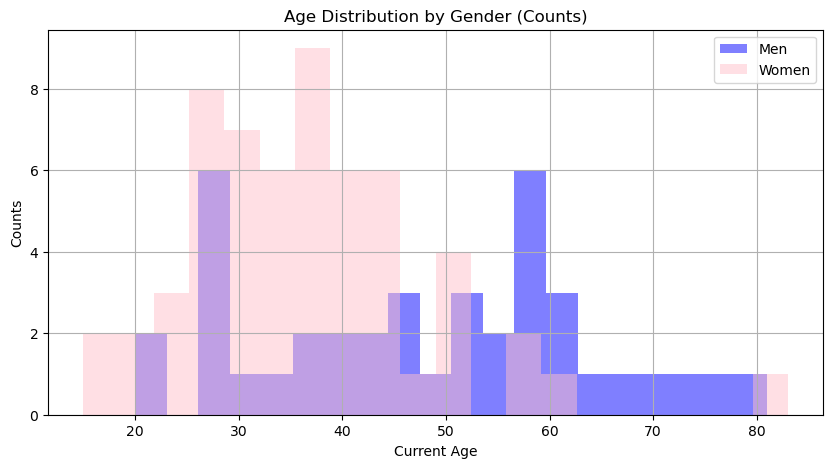

In [36]:
# your code here
df['current_age'] = 2023 - df['year_born']
df = df[df['primary_role'].isin(['actor', 'actress'])]
# Filter the DataFrame for men and women
men_df = df[df['gender'] == 'male']
women_df = df[df['gender'] == 'female']

plt.figure(figsize=(10, 5))
plt.hist(men_df['current_age'], bins=20, alpha=0.5, color='blue', label='Men', density=True)
plt.hist(women_df['current_age'], bins=20, alpha=0.5, color='pink', label='Women', density=True)
plt.title('Normalized Age Distribution by Gender')
plt.xlabel('Current Age')
plt.ylabel('Proportion')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(men_df['current_age'], bins=20, alpha=0.5, color='blue', label='Men', density=False)
plt.hist(women_df['current_age'], bins=20, alpha=0.5, color='pink', label='Women', density=False)
plt.title('Age Distribution by Gender (Counts)')
plt.xlabel('Current Age')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q10.3 - Credits Per Year</b></div>

Create a [box plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot) or [violin plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.violin.html?highlight=violin#matplotlib.axes.Axes.violin) comparing the **credits-per-year-active** for men and women performers.

Here we assume all stars in the list are still active. 

Do these distributions look the same across genders? Can you identify the stars corresponding to any outliers? Comment on these points and anything else of interest gleaned from your plot. (6 sentences or fewer)

>**NOTE:** Again, you should exclude those whose `primary_role` is not 'actor' or 'actress' from your analysis.
</div>

##TBD

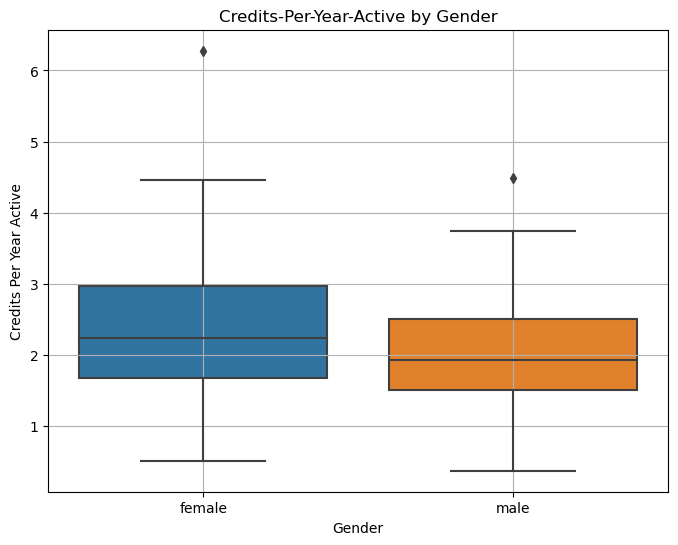

In [37]:
# your code here
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
f = df[df['primary_role'].isin(['actor', 'actress'])]

# Calculate credits per year active for each performer
df['credits_per_year'] = df['num_credits'] / (2023-df['year_first_credit'])

# Create a box plot comparing credits-per-year-active for men and women
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='credits_per_year', data=df)
plt.title('Credits-Per-Year-Active by Gender')
plt.xlabel('Gender')
plt.ylabel('Credits Per Year Active')
plt.grid(True)
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q11 - Most Prolific Stars</b></div>

Make a plot visualizing the number of credits received by each star. Who is the most prolific person in our snapshot of IMDb's starmeter? Define **most prolific** as the person with the most credits.

>**Note 1:** Your analysis should include all 100 stars
>
>**Note 2:** The stars in the plots should be sorted based on number of credits to make the plot easier to read.
</div>

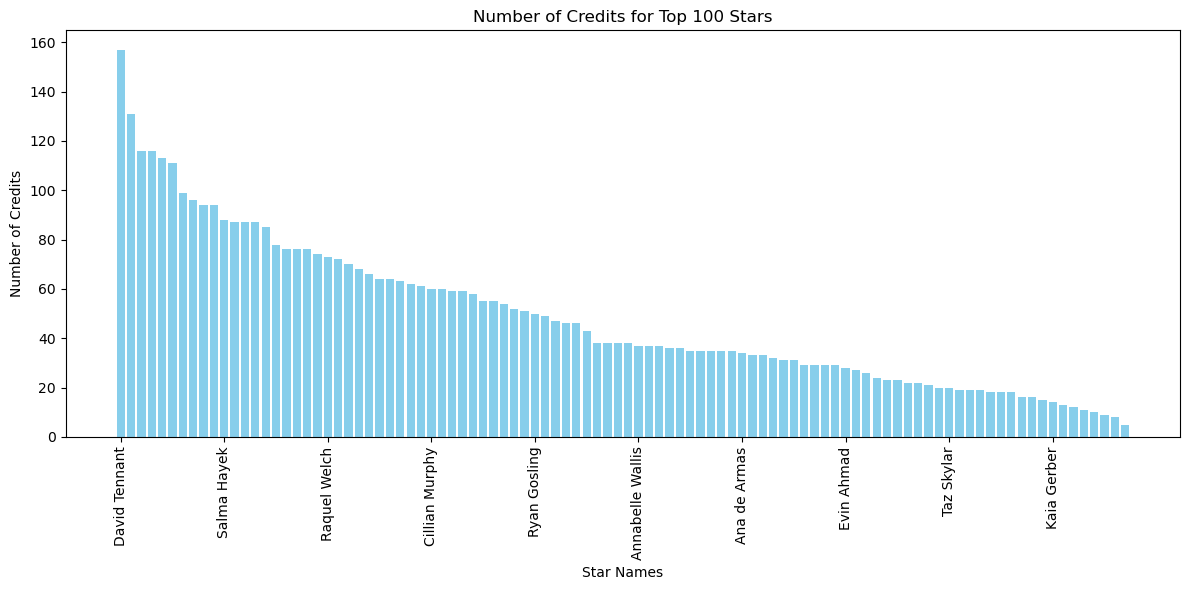

In [38]:
df_sorted = df.sort_values(by='num_credits', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_sorted['name'], df_sorted['num_credits'], color='skyblue')
plt.xlabel('Star Names')
plt.ylabel('Number of Credits')
plt.title('Number of Credits for Top 100 Stars')
plt.xticks(range(0, len(df_sorted), 10), df_sorted['name'][::10], rotation=90)

plt.tight_layout()
plt.show()

In [39]:
highest_performer_name = df_sorted.iloc[0]['name']
highest_performer_credits = df_sorted.iloc[0]['num_credits']
print ("{} had the most credits with {}".format(highest_performer_name, highest_performer_credits))

David Tennant had the most credits with 157


<!-- END QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>🌈 BONUS - Additional EDA (ungraded)</b></div>

Feel free to use this space to perform additional EDA. We will share any of your interesting insights or visualizations with the rest of the class!
</div>

In [40]:
# your (optional) code here


**This concludes HW1. Thank you!**